In [15]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

# Load the data
merged_data = gpd.read_file(r"D:\datascienEO\merged_data_allmonths_allbands_cloud20.geojson")

# Encode species labels to integers
unique_species = merged_data['l3_species'].unique()
species_to_index = {species: idx for idx, species in enumerate(unique_species)}
labels = merged_data['l3_species'].map(species_to_index).values
num_classes = len(unique_species)

In [16]:
# Encode species labels to integers
unique_species = merged_data['l3_species'].unique()
species_to_index = {species: idx for idx, species in enumerate(unique_species)}
labels = merged_data['l3_species'].map(species_to_index).values
num_classes = len(unique_species)

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=num_classes)


In [35]:
# Count the occurrences of each species in the dataset
class_counts = merged_data['l3_species'].value_counts()

print("Class Distribution:")
print(class_counts)


Class Distribution:
l3_species
scots pine        14178
norway spruce     10184
european beech     9297
english oak        7085
birch              5785
alder              5289
douglas fir        5136
european ash       4518
sessile oak        4484
sycamore maple     4190
japanese larch     4078
red oak            3435
european larch     2494
silver fir         2090
weymouth pine      1259
black pine         1092
poplar             1029
cherry              455
linden              367
Name: count, dtype: int64


In [33]:
import ast

# Extract selected band data as a 2D array
bands = ['B3', 'B4', 'B8', 'NDVI', 'B11', 'B6']
for band in bands:
    merged_data[band] = merged_data[band].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

rows = len(merged_data)
X = np.zeros((rows, len(bands) * 11 * 11), dtype=np.float32)

for i in range(rows):
    band_stack = []
    for band in bands:
        if isinstance(merged_data[band][i], list):  # Ensure it's a list
            band_stack.append(np.array(merged_data[band][i], dtype=np.float32).flatten())
    X[i, :] = np.concatenate(band_stack, axis=0) if band_stack else np.zeros(len(bands) * 11 * 11)

# Normalize data to [0, 1]
X = X / 10000

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=24, shuffle=True)

# Define MLP model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
#model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))




# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [37]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

Epoch 1/100
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.2720 - loss: 2.3039 - val_accuracy: 0.2686 - val_loss: 2.3044
Epoch 2/100
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.2752 - loss: 2.2970 - val_accuracy: 0.2767 - val_loss: 2.3085
Epoch 3/100
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.2810 - loss: 2.2813 - val_accuracy: 0.2727 - val_loss: 2.2882
Epoch 4/100
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2817 - loss: 2.2813 - val_accuracy: 0.2837 - val_loss: 2.2866
Epoch 5/100
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.2845 - loss: 2.2724 - val_accuracy: 0.2838 - val_loss: 2.2648
Epoch 6/100
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2849 - loss: 2.2677 - val_accuracy: 0.2875 - val_loss: 2.2642
Epoch 7/100
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2845 - loss: 2.2765 - val_accuracy: 0.2764 - val_loss: 2.2782
Epoch 8/100
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2886 - loss: 2

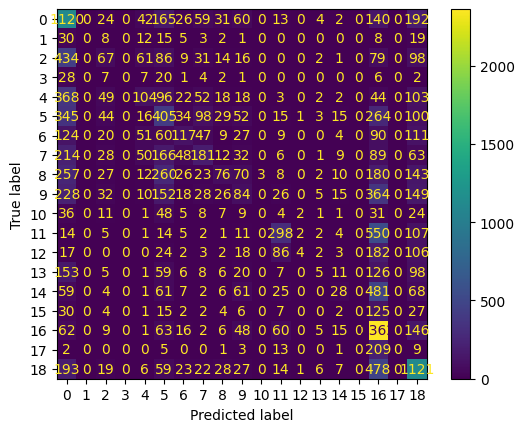

Accuracy with MLP:  0.34542194458904507


In [38]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_classes, y_pred_classes)
plt.show()

# Print accuracy
acc = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy with MLP: ", acc)
